# STENCIL-NET for Signal-Noise Decomposition KdV equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from stencilnet import MLPConv, forward_rk3_tvd_error, backward_rk3_tvd_error
from utils import burgers_simulation, forcing_terms, noise_initialization, load_denoising_model
from tqdm import tqdm_notebook as tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [3]:
data = sio.loadmat("data/kdv_raissi.mat")

u = data["sim_u"]
x = data["x_space"][0]
t = data["tspan"][0]

dx = x[1] - x[0]
dt = t[1] - t[0]

print("u shape", u.shape)

u shape (256, 101)


## Subsample Solution Data and Add Noise

In [4]:
t_factor = 2   # time subsample factor 
s_factor = 8   # space subsample factor

dxc = s_factor*dx
dtc = t_factor*dt

coarse_x = np.arange(0,u.shape[0],s_factor)
coarse_t = np.arange(0,u.shape[1],t_factor)

np.random.seed(0)
noise_level  = 0.3
u_coarse     = np.zeros((len(coarse_x),len(coarse_t)))
for i,_x in enumerate(coarse_t):
    u_coarse[:,i] = u[coarse_x,coarse_t[i]].real
    
u_coarse_noise = u_coarse + noise_level*np.std(u_coarse)*np.random.randn(u_coarse.shape[0],u_coarse.shape[1])

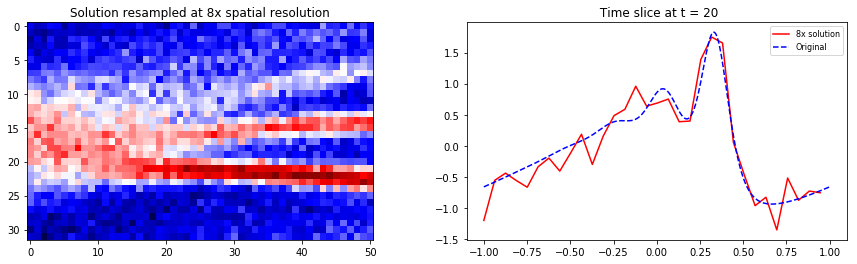

In [5]:
time = 20

plt.subplot(1,2,1)
plt.title("Solution resampled at " + str(s_factor) + "x spatial resolution")
plt.imshow(u_coarse_noise, cmap='seismic', aspect=1)

plt.subplot(1,2,2)
plt.title(" Time slice at t = " + str(time))
plt.plot(x[coarse_x], u_coarse_noise[:,time],'-',color='red',label=str(s_factor) + 'x solution')
plt.plot(x, u[:,t_factor*time],'--',color='blue',label='Original')
plt.legend(loc='best', prop={'size':8})
plt.gcf().set_size_inches(15,4)

In [6]:
u_coarse_train = u_coarse_noise
Lxc, Ltc = u_coarse_train.shape

## Training or Load Pre-trained Model

You may choose to run the training procedure yourself (~30min depending on data size) or load one of the already pre-trained models below.

### Train Model

In [7]:
# define trainig data
u_train = torch.tensor(u_coarse_train.T, requires_grad=True, dtype=torch.float, device=device)

# initialize noise estimate using tikhonov-regularization
noise_init = noise_initialization(u_coarse_train, lam=0.1)
noise      = torch.tensor(noise_init.T, requires_grad=True, dtype=torch.float, device=device)

In [8]:
seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# size of filter to be applied
fs = 7

net       = MLPConv([fs, 64, 64, 64, 1], seed=seed, fs=fs, noise=noise, activation=nn.ELU()).to(device)
params    = [{'params': net.parameters(), 'lr': 1e-3}]
optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)

print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))

# number of timesteps to be predicted during training 
m = 4 

# decaying weights for accumulating prediction error
decay_const = 0.9
output_weights = [decay_const**j for j in range(m+1)] 
wd = torch.tensor(output_weights, dtype=torch.float32, device=device)

epochs = 30_000
l_wd   = 1e-7
l_n    = 1e-5

pbar = tqdm(range(epochs))
for epoch in pbar:
    optimizer.zero_grad()
    
    # compute forward and backward prediction errors
    fwd = forward_rk3_tvd_error(net, u_train, dtc, m, wd)
    bwd = backward_rk3_tvd_error(net, u_train, dtc, m, wd)
    
    # noise regularization
    reg_n = torch.sum(net.noise.reshape(Lxc*Ltc,-1)**2)
    
    # compute norm of weights
    res_w = 0
    for i in range(len(net.layer)):
        W = net.layer[i].weight
        W = W.view(W.shape[0]*W.shape[1], -1)
        res_w = res_w + (torch.norm(W, p=2, dim=0)**2)
        
    loss =  fwd + bwd + l_n*reg_n + l_wd*res_w
    
    loss.backward()
    optimizer.step()
    
    if epoch > 15_000:
        scheduler.step()
        
    pbar.set_postfix(loss=round(loss.item(), 7))

input 7 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 10529


### Load Model

You can load pre-trained models for a `s_factor` of 2, 4 or 8 with a `t_factor` of 2. For each there are two models with one MLPConv unit of three layers and 32 or 64 neurons.

In [8]:
neurons = 64
net = load_denoising_model(s_factor, t_factor, neurons, device)

## Recontruction of Training Data

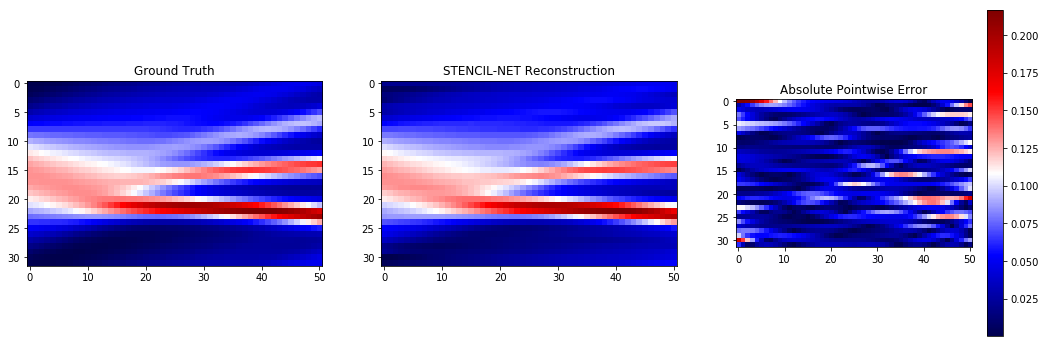

In [9]:
plt.subplot(1,3,1)
plt.imshow(u_coarse, cmap="seismic")
plt.title("Ground Truth")

recon = u_coarse_train - net.noise.cpu().data.numpy().T

plt.subplot(1,3,2)
plt.imshow(recon, cmap="seismic")
plt.title("STENCIL-NET Reconstruction")

plt.subplot(1,3,3)
plt.imshow(np.abs(u_coarse - recon), cmap="seismic")
plt.colorbar()
plt.title("Absolute Pointwise Error")

plt.gcf().set_size_inches(18,6)
plt.show()

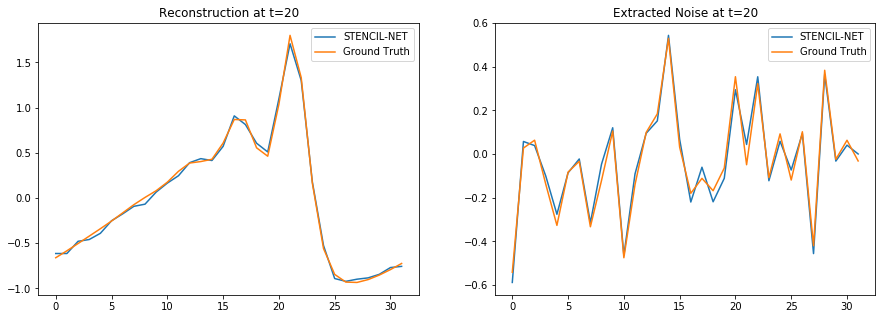

In [10]:
time = 20

plt.subplot(1,2,1)
plt.plot(recon[:,time], label="STENCIL-NET")
plt.plot(u_coarse[:,time], label="Ground Truth")
plt.title("Reconstruction at t={}".format(time))
plt.legend()

plt.subplot(1,2,2)
plt.plot(net.noise.cpu().data.numpy().T[:,time], label="STENCIL-NET")
plt.plot(u_coarse_noise[:,time]-u_coarse[:,time], label="Ground Truth")
plt.title("Extracted Noise at t={}".format(time))
plt.legend()

plt.gcf().set_size_inches(15,5)